In [129]:
%%html
<style>
body {
    font-family: "Cambria", cursive, sans-serif;
}
</style> 

In [1]:
import random, time
import numpy as np
from collections import defaultdict
import operator
import matplotlib.pyplot as plt

## Misc functions and utilities

In [2]:
orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)

In [3]:
def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

In [4]:
def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)

def turn_left(heading):
    return turn_heading(heading, LEFT)

def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return math.hypot((xA - xB), (yA - yB))

In [5]:
def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')

## Class definitions

### Base `MDP` class

In [6]:
class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state."""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        #if self.transitions == {}:
            #print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

### A custom MDP class to extend functionality
We will write a CustomMDP class to extend the MDP class for the problem at hand. <br>This class will implement the `T` method to implement the transition model.

In [7]:
class CustomMDP(MDP):

    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        #print(actlist)

        MDP.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.reward = rewards
        for state in self.t:
            self.states.add(state)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return [(prob, new_state) for new_state, prob in self.t[state][action].items()]

## Problem 1: Simple MDP

---
### State dependent reward function
Markov Decision Processes are formally described as processes that follow the Markov property which states that "The future is independent of the past given the present". MDPs formally describe environments for reinforcement learning and we assume that the environment is fully observable.

Let us take a toy example MDP and solve it using value iteration and policy iteration. This is a simple example adapted from a similar problem by Dr. David Silver, tweaked to fit the limitations of the current functions.

Let's say you're a student attending lectures in a university. There are three lectures you need to attend on a given day. Attending the first lecture gives you 4 points of reward. After the first lecture, you have a 0.6 probability to continue into the second one, yielding 6 more points of reward. But, with a probability of 0.4, you get distracted and start using Facebook instead and get a reward of -1. From then onwards, you really can't let go of Facebook and there's just a 0.1 probability that you will concentrate back on the lecture.

After the second lecture, you have an equal chance of attending the next lecture or just falling asleep. Falling asleep is the terminal state and yields you no reward, but continuing on to the final lecture gives you a big reward of 10 points. From there on, you have a 40% chance of going to study and reach the terminal state, but a 60% chance of going to the pub with your friends instead. You end up drunk and don't know which lecture to attend, so you go to one of the lectures according to the probabilities given above.

![](https://raw.githubusercontent.com/aimacode/aima-python/c16bb8bdc28e8f9fcc6e7f76a92b9492bf019d87/images/mdp-b.png)

### Definition of transition matrix
We first have to define our Transition Matrix as a nested dictionary to fit the requirements of the MDP class.

In [8]:
t = {
    'leisure': {
                    'facebook': {'leisure':0.9, 'class1':0.1},
                    'quit': {'leisure':0.1, 'class1':0.9},
                    'study': {},
                    'sleep': {},
                    'pub': {}
               },
    'class1': {
                    'study': {'class2':0.6, 'leisure':0.4},
                    'facebook': {'class2':0.4, 'leisure':0.6},
                    'quit': {},
                    'sleep': {},
                    'pub': {}
              },
    'class2': {
                    'study': {'class3':0.5, 'end':0.5},
                    'sleep': {'end':0.5, 'class3':0.5},
                    'facebook': {},
                    'quit': {},
                    'pub': {},
              },
    'class3': {
                    'study': {'end':0.6, 'class1':0.08, 'class2':0.16, 'class3':0.16},
                    'pub': {'end':0.4, 'class1':0.12, 'class2':0.24, 'class3':0.24},
                    'facebook': {},
                    'quit': {},
                    'sleep': {}
              },
    'end': {}
}

### Defining rewards
We now need to define the reward for each state.

In [9]:
rewards = {
    'class1': 4,
    'class2': 6,
    'class3': 10,
    'leisure': -1,
    'end': 0
}

### Terminal state
This MDP has only one terminal state

In [10]:
terminals = ['end']

### Setting initial state to `Class 1`

In [11]:
init = 'class1'

### Read in an instance of the custom class

In [12]:
school_mdp = CustomMDP(t, rewards, terminals, init, gamma=.95)

### Let's see the actions and rewards of the MDP

In [13]:
school_mdp.states

{'class1', 'class2', 'class3', 'end', 'leisure'}

In [14]:
school_mdp.actions('class1')

['pub', 'study', 'facebook', 'sleep', 'quit']

In [15]:
school_mdp.actions('leisure')

['pub', 'study', 'facebook', 'sleep', 'quit']

In [16]:
school_mdp.T('class1','sleep')

[]

In [17]:
school_mdp.actions('end')

[None]

In [18]:
school_mdp.reward

{'class1': 4, 'class2': 6, 'class3': 10, 'end': 0, 'leisure': -1}

## Value iteration

In [19]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration.
    mdp: The MDP object
    epsilon: Stopping criteria
    """
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return U

In [20]:
def value_iteration_over_time(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

In [21]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action."""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

## Value iteration on the school MDP

In [22]:
value_iteration(school_mdp)

{'class1': 20.306571436730533,
 'class2': 15.792664558035112,
 'class3': 20.61614864677164,
 'end': 0.0,
 'leisure': 18.079639654154484}

In [23]:
value_iteration_over_time(school_mdp,iterations=10)

[{'class1': 0, 'class2': 0, 'class3': 0, 'end': 0, 'leisure': 0},
 {'class1': 4.0, 'class2': 6.0, 'class3': 10.0, 'end': 0.0, 'leisure': -1.0},
 {'class1': 7.039999999999999,
  'class2': 10.75,
  'class3': 14.104,
  'end': 0.0,
  'leisure': 2.3249999999999997},
 {'class1': 11.011,
  'class2': 12.699399999999999,
  'class3': 16.469271999999997,
  'end': 0.0,
  'leisure': 5.240074999999999},
 {'class1': 13.2298865,
  'class2': 13.822904199999998,
  'class3': 17.905711216,
  'end': 0.0,
  'leisure': 8.912212125},
 {'class1': 15.265696001499999,
  'class2': 14.5052128276,
  'class3': 18.742331375847996,
  'end': 0.0,
  'leisure': 11.158213109375},
 {'class1': 16.5080922932945,
  'class2': 14.902607403527798,
  'class3': 19.320729422557143,
  'end': 0.0,
  'leisure': 13.112200326673124},
 {'class1': 17.47712234414663,
  'class2': 15.177346475714643,
  'class3': 19.68484331778294,
  'end': 0.0,
  'leisure': 14.360077941800741},
 {'class1': 18.10791710904163,
  'class2': 15.350300575946896,
 

### Plotting value updates over time/iterations

In [24]:
def plot_value_update(mdp,iterations=10,plot_kw=None):
    """
    Plot value updates over iterations for a given MDP.
    """
    x = value_iteration_over_time(mdp,iterations=iterations)
    value_states = {k:[] for k in mdp.states}
    for i in x:
        for k,v in i.items():
            value_states[k].append(v)
           
    plt.figure(figsize=(8,5))
    plt.title("Evolution of state utilities over iteration", fontsize=18)
    for v in value_states:
        plt.plot(value_states[v])
        plt.legend(list(value_states.keys()),fontsize=14)
    plt.grid(True)
    plt.xlabel("Iterations",fontsize=16)
    plt.ylabel("Utilities of states",fontsize=16)
    plt.show()

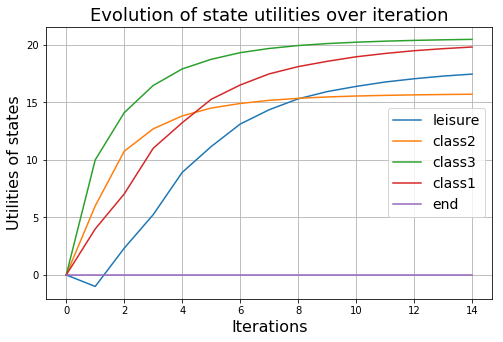

In [25]:
plot_value_update(school_mdp,15)

### Value iterations for various discount factors ($\gamma$)

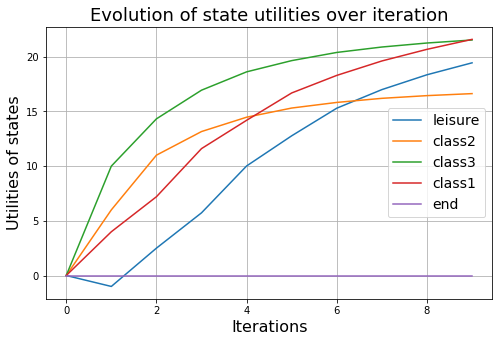

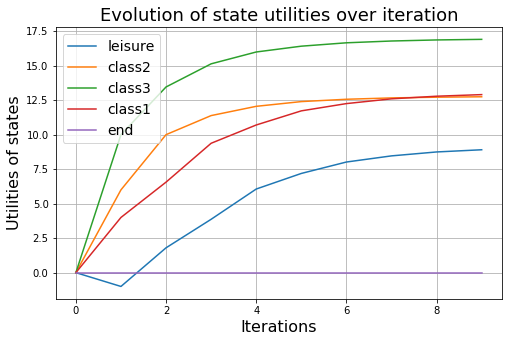

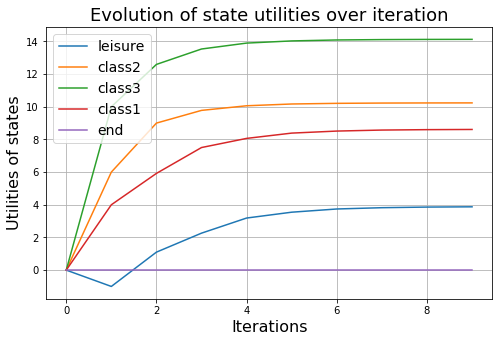

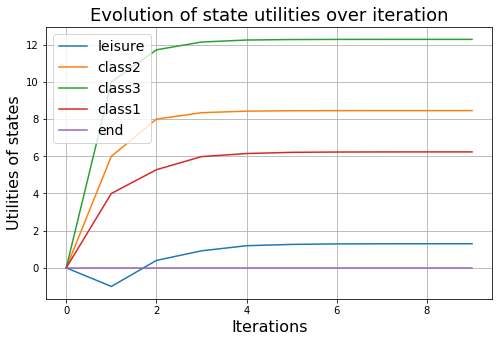

In [26]:
for i in range(4):
    mdp = CustomMDP(t, rewards, terminals, init, gamma=1-0.2*i)
    plot_value_update(mdp,10)

### Value iteration for two different reward structures

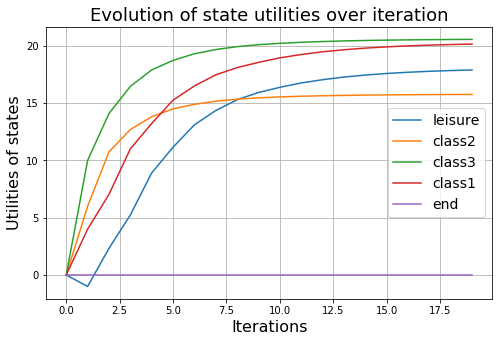

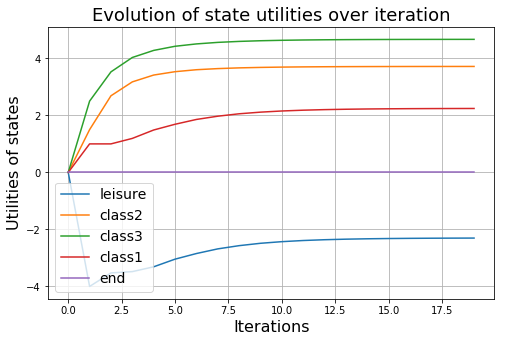

In [27]:
rewards1 = {
    'class1': 4,
    'class2': 6,
    'class3': 10,
    'leisure': -1,
    'end': 0
}

mdp1 = CustomMDP(t, rewards1, terminals, init, gamma=.95)
plot_value_update(mdp1,20)

rewards2 = {
    'class1': 1,
    'class2': 1.5,
    'class3': 2.5,
    'leisure': -4,
    'end': 0
}

mdp2 = CustomMDP(t, rewards2, terminals, init, gamma=.95)
plot_value_update(mdp2,20)

In [28]:
value_iteration(mdp2)

{'class1': 2.245184728702343,
 'class2': 3.717135902670662,
 'class3': 4.667674180844613,
 'end': 0.0,
 'leisure': -2.2988059489639867}

## Policy iteration

In [29]:
def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

In [30]:
def policy_evaluation(pi, U, mdp, k=20):
    """Returns an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""
    
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum([p * U[s1] for (p, s1) in T(s, pi[s])])
    return U

In [31]:
def policy_iteration(mdp,verbose=0):
    """Solves an MDP by policy iteration"""
    
    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    if verbose:
        print("Initial random choice:",pi)
    iter_count=0
    while True:
        iter_count+=1
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return (pi,iter_count)
        if verbose:
            print("Policy after iteration {}: {}".format(iter_count,pi))

## Policy iteration over the school MDP

In [32]:
policy_iteration(school_mdp)

({'class1': 'facebook',
  'class2': 'study',
  'class3': 'pub',
  'end': None,
  'leisure': 'quit'},
 3)

In [33]:
policy_iteration(school_mdp,verbose=1)

Initial random choice: {'leisure': 'study', 'class2': 'sleep', 'class3': 'facebook', 'class1': 'pub', 'end': None}
Policy after iteration 1: {'leisure': 'quit', 'class2': 'study', 'class3': 'pub', 'class1': 'study', 'end': None}
Policy after iteration 2: {'leisure': 'quit', 'class2': 'study', 'class3': 'pub', 'class1': 'facebook', 'end': None}


({'class1': 'facebook',
  'class2': 'study',
  'class3': 'pub',
  'end': None,
  'leisure': 'quit'},
 3)

### Does the result match using value iteration? We use the `best_policy` function to find out

In [34]:
best_policy(school_mdp,value_iteration(school_mdp,0.01))

{'class1': 'facebook',
 'class2': 'study',
 'class3': 'pub',
 'end': None,
 'leisure': 'quit'}

## Comparing computation efficiency (time) of value and policy iterations
Clearly values iteration method takes more iterations to reach the same steady-state compared to policy iteration technique. But how does their computation time compare? Let's find out.

### Running value and policy iteration on the school MDP many times and averaging

In [35]:
def compute_time(mdp,iteration_technique='value',n_run=1000,epsilon=0.01):
    """
    Computes the average time for value or policy iteration for a given MDP
    n_run: Number of runs to average over, default 1000
    epsilon: Error margin for the value iteration
    """
    if iteration_technique=='value':
        t1 = time.time()
        for _ in range(n_run):
            value_iteration(mdp,epsilon=epsilon)
        t2 = time.time()
        print("Average value iteration took {} milliseconds".format((t2-t1)*1000/n_run))
    else:
        t1 = time.time()
        for _ in range(n_run):
            policy_iteration(mdp)
        t2 = time.time()

        print("Average policy iteration took {} milliseconds".format((t2-t1)*1000/n_run))

In [36]:
compute_time(school_mdp,'value')

Average value iteration took 1.551398515701294 milliseconds


In [37]:
compute_time(school_mdp,'policy')

Average policy iteration took 0.7556800842285156 milliseconds


## Q-learning

### Q-learning class

In [38]:
class QLearningAgent:
    """ An exploratory Q-learning agent. It avoids having to learn the transition
        model because the Q-value of a state can be related directly to those of
        its neighbors.
    """
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act = mdp.actlist
        self.Ne = Ne  # iteration limit in exploration function
        self.Rplus = Rplus  # large value to assign before iteration limit
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(float)
        self.s = None
        self.a = None
        self.r = None
        self.states = mdp.states
        self.T = mdp.T

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1./(1+n)

    def f(self, u, n):
        """ Exploration function. Returns fixed Rplus until
        agent has visited state, action a Ne number of times."""
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Return actions possible in given state.
            Useful for max and argmax. """
        if state in self.terminals:
            return [None]
        else:
            act_list=[]
            for a in self.all_act:
                if len(self.T(state,a))>0:
                    act_list.append(a)
            return act_list

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals,
        actions_in_state = self.actions_in_state

        if s in terminals:
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1]
                                           for a1 in actions_in_state(s1)) - Q[s, a])
        if s in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1]))
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept

### Trial run

In [39]:
def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp."""

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

### Testing Q-learning

In [40]:
# Define an agent
q_agent = QLearningAgent(school_mdp, Ne=1000, Rplus=2,alpha=lambda n: 60./(59+n))

In [41]:
q_agent.actions_in_state('leisure')

['facebook', 'quit']

In [42]:
run_single_trial(q_agent,school_mdp)

In [43]:
q_agent.Q

defaultdict(float,
            {('class1', 'facebook'): 0.0,
             ('class1', 'study'): 4.0,
             ('class2', 'sleep'): 0.0,
             ('class2', 'study'): 6.0,
             ('class3', 'pub'): 10.0,
             ('class3', 'study'): 0.0,
             ('end', None): 0.0})

In [44]:
for i in range(200):
    run_single_trial(q_agent,school_mdp)

In [45]:
q_agent.Q

defaultdict(float,
            {('class1', 'facebook'): 0.0,
             ('class1', 'study'): 21.102026735424506,
             ('class2', 'sleep'): 0.0,
             ('class2', 'study'): 19.704731967971327,
             ('class3', 'pub'): 31.293753554566774,
             ('class3', 'study'): 0.0,
             ('end', None): 9.623141136361212,
             ('leisure', 'facebook'): 3.2717209129607285,
             ('leisure', 'quit'): 0.0})

In [50]:
def get_U_from_Q(q_agent):
    U = defaultdict(lambda: -100.) # Large negative value for comparison
    for state_action, value in q_agent.Q.items():
        state, action = state_action
        if U[state] < value:
                    U[state] = value
    return U

In [51]:
get_U_from_Q(q_agent)

defaultdict(<function __main__.get_U_from_Q.<locals>.<lambda>>,
            {'class1': 23.240778964819558,
             'class2': 19.269040298105956,
             'class3': 24.118980496477,
             'end': 4.003615097285804,
             'leisure': 20.859406847898033})

In [52]:
q_agent = QLearningAgent(school_mdp, Ne=100, Rplus=25,alpha=lambda n: 10/(9+n))
qhistory=[]
for i in range(100000):
    run_single_trial(q_agent,school_mdp)
    U=get_U_from_Q(q_agent)
    qhistory.append(U)
print(get_U_from_Q(q_agent))

defaultdict(<function get_U_from_Q.<locals>.<lambda> at 0x00000255290A4F28>, {'class1': 23.240828242090135, 'class2': 19.233409838752596, 'end': 4.003615106646801, 'class3': 24.108995803027188, 'leisure': 20.878772382041472})


In [53]:
print(value_iteration(school_mdp,epsilon=0.001))

{'leisure': 18.079639654154484, 'class2': 15.792664558035112, 'class3': 20.61614864677164, 'class1': 20.306571436730533, 'end': 0.0}


### Function for utility estimate by Q-learning by many iterations

In [59]:
def qlearning_iter(agent_program,mdp,iterations=1000,print_final_utility=True):
    """
    Function for utility estimate by Q-learning by many iterations
    Returns a history object i.e. a list of dictionaries, where utility estimate for each iteration is stored
    
    q_agent = QLearningAgent(grid_1, Ne=25, Rplus=1.5,
                            alpha=lambda n: 10000./(9999+n))
    hist=qlearning_iter(q_agent,grid_1,iterations=10000)
    
    """
    qhistory=[]
    
    for i in range(iterations):
        run_single_trial(agent_program,mdp)
        U=get_U_from_Q(agent_program)
        if len(U)==len(mdp.states):
            qhistory.append(U)
    
    if print_final_utility:
        print(U)
    return qhistory

### How do the long-term utility estimates with Q-learning compare with value iteration?

In [60]:
def plot_qlearning_vi(hist, vi,plot_n_states=None):
    """
    Compares and plots a Q-learning and value iteration results for the utility estimate of an MDP's states
    hist: A history object from a Q-learning run
    vi: A value iteration estimate for the same MDP
    plot_n_states: Restrict the plotting for n states (randomly chosen)
    """
    
    utilities={k:[] for k in list(vi.keys())}
    for h in hist:
        for state in h.keys():
            utilities[state].append(h[state])
    
    if plot_n_states==None:
        for state in list(vi.keys()):
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()
    else:
        for state in list(vi.keys())[:plot_n_states]:
            plt.figure(figsize=(7,4))
            plt.title("Plot of State: {} over Q-learning iterations".format(str(state)),fontsize=16)
            plt.plot(utilities[state])
            plt.hlines(y=vi[state],xmin=0,xmax=1.1*len(hist))
            plt.legend(['Q-learning estimates','Value iteration estimate'],fontsize=14)
            plt.xlabel("Iterations",fontsize=14)
            plt.ylabel("Utility of the state",fontsize=14)
            plt.grid(True)
            plt.show()

### Testing the long-term utility learning for the small (default) grid world

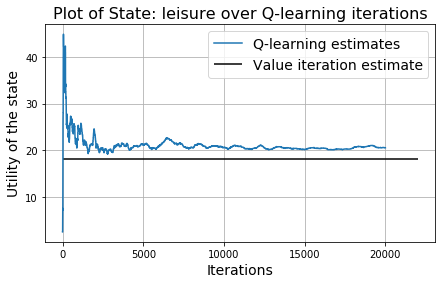

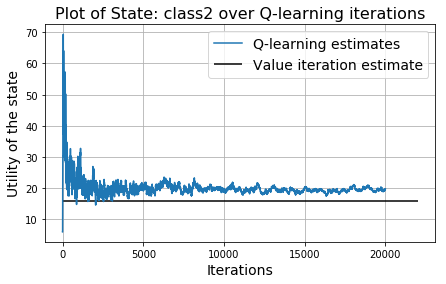

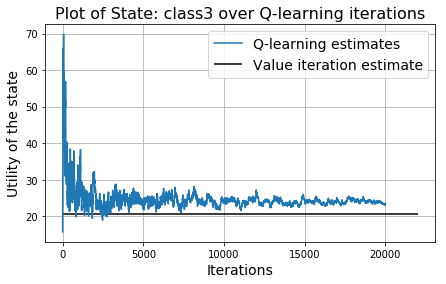

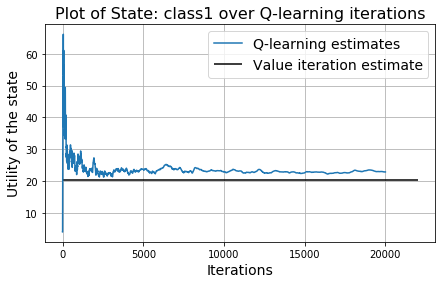

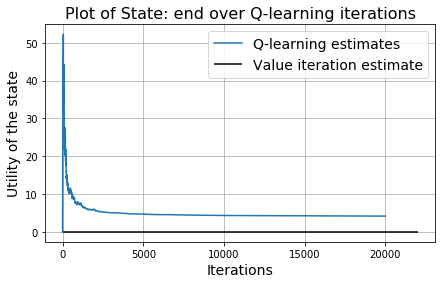

In [56]:
# Define the Q-learning agent
q_agent = QLearningAgent(school_mdp, Ne=100, Rplus=2,alpha=lambda n: 100/(99+n))
# Obtain the history by running the Q-learning for many iterations
hist=qlearning_iter(q_agent,school_mdp,iterations=20000,print_final_utility=False)
# Get a value iteration estimate using the same MDP
vi = value_iteration(school_mdp,epsilon=0.001)
# Compare the utility estimates from two methods
plot_qlearning_vi(hist,vi)

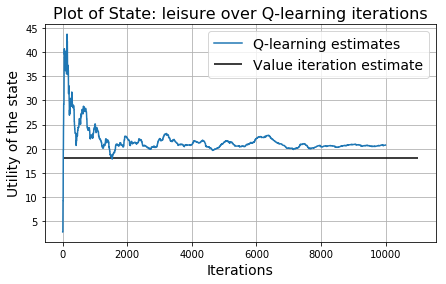

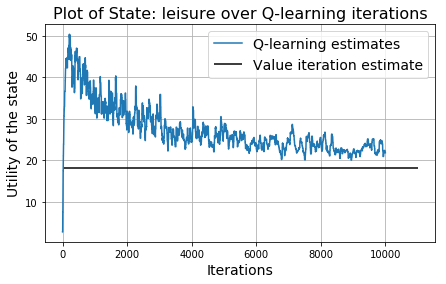

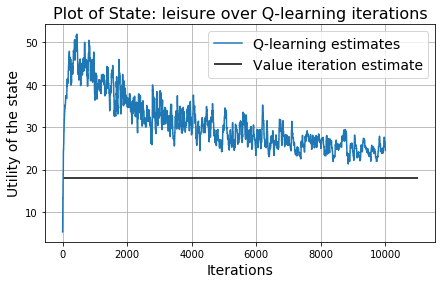

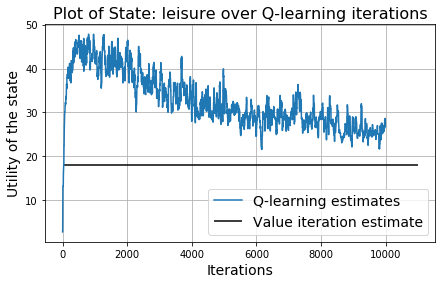

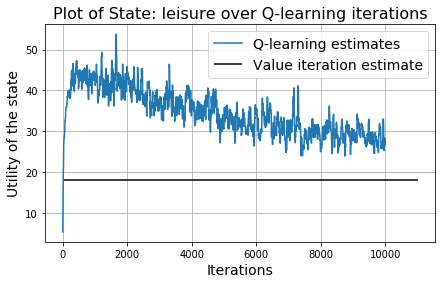

In [76]:
for alpha in range(100,5100,1000):
    q_agent = QLearningAgent(school_mdp, Ne=10, Rplus=2,alpha=lambda n: alpha/(alpha-1+n))
    # Obtain the history by running the Q-learning for many iterations
    hist=qlearning_iter(q_agent,school_mdp,iterations=10000,print_final_utility=False)
    # Get a value iteration estimate using the same MDP
    vi = value_iteration(school_mdp,epsilon=0.001)
    # Compare the utility estimates from two methods
    plot_qlearning_vi(hist,vi,plot_n_states=1)